# Self Organizing Maps

Aqui utilizamos um dataset que classifica países em quatro níveis diferentes de governo. Democracia completa, democracia parcial, hibrido e autoritário. Além disso, para cada país são dadas várias métricas númericas para índices com alguma relação a essa classificação.

Com isso, utilizamos a biblioteca minisom para obter algumas visualizações desse dataset através de Self Organizing Maps.

## Instalando dependências necessárias

In [1]:
pip install numpy pandas matplotlib sklearn minisom html5lib lxml beautifulsoup4 


Note: you may need to restart the kernel to use updated packages.


## Importando tudo

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
import seaborn as sn
from matplotlib.pyplot import figure
from matplotlib.patches import Patch
from sklearn.tree import DecisionTreeRegressor
import re

## Lendo  dataset

In [3]:
democracy_index = pd.read_csv('democracy_index.csv')
democracy_index.head(10)

,Unnamed: 0,rank,country,democracy_index,electoral_processand_pluralism,functioning_of_government,political_participation,political_culture,civil_liberties,category
0,0,1,Norway,9.87,10.00,9.64,10.00,10.00,9.71,Full democracy
1,1,2,Iceland,9.58,10.00,9.29,8.89,10.00,9.71,Full democracy
2,2,3,Sweden,9.39,9.58,9.64,8.33,10.00,9.41,Full democracy
3,3,4,New Zealand,9.26,10.00,9.29,8.89,8.13,10.00,Full democracy
4,4,5,Denmark,9.22,10.00,9.29,8.33,9.38,9.12,Full democracy
5,5,=6,Ireland,9.15,9.58,7.86,8.33,10.00,10.00,Full democracy
6,6,=6,Canada,9.15,9.58,9.64,7.78,8.75,10.00,Full democracy
7,7,8,Finland,9.14,10.00,8.93,8.33,8.75,9.71,Full democracy
8,8,9,Australia,9.09,10.00,8.93,7.78,8.75,10.00,Full democracy
9,9,10,Switzerland,9.03,9.58,9.29,7.78,9.38,9.12,Full democracy


## Feature Selection

In [4]:
feature_names = ['democracy_index', 'electoral_processand_pluralism', 'functioning_of_government',
                 'political_participation', 'political_culture', 'civil_liberties']

X = democracy_index[feature_names].values

X = scale(X)

feature_df = pd.DataFrame(X, columns=feature_names)
target = feature_df.iloc[:,0]
Features = feature_df.iloc[:,1:]

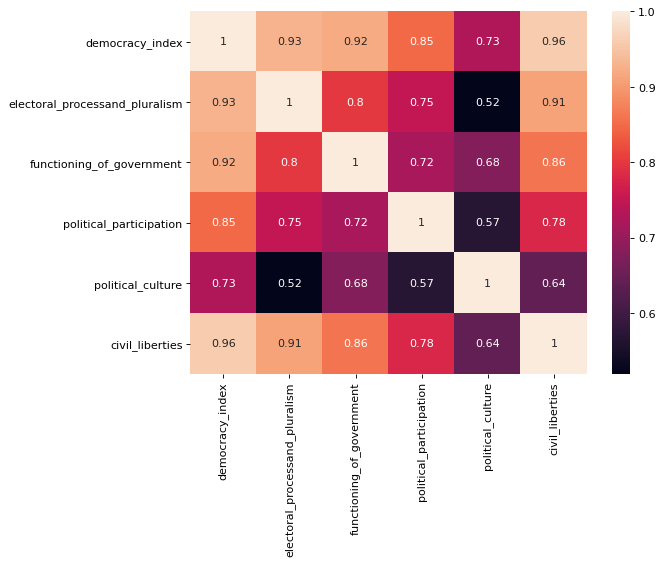

In [5]:
figure(figsize=(8, 6), dpi=80)
feat_num = len(feature_names)
corrMatrix = feature_df.corr().round(2)
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Verificando a caracteristica mais relevante na classificação

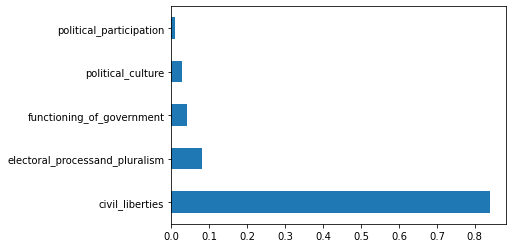

In [6]:
model = DecisionTreeRegressor(random_state=0)
model.fit(Features, target)
feat_importances = pd.Series(model.feature_importances_, index=Features.columns)
feat_importances.nlargest(Features.shape[1]).plot(kind='barh')
plt.show()

In [7]:
size = 15
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [  496 / 1000 ]  50% - 0:00:00 left 

 [  992 / 1000 ]  99% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.35464600769383864


## Mapeamento com os países por classificação

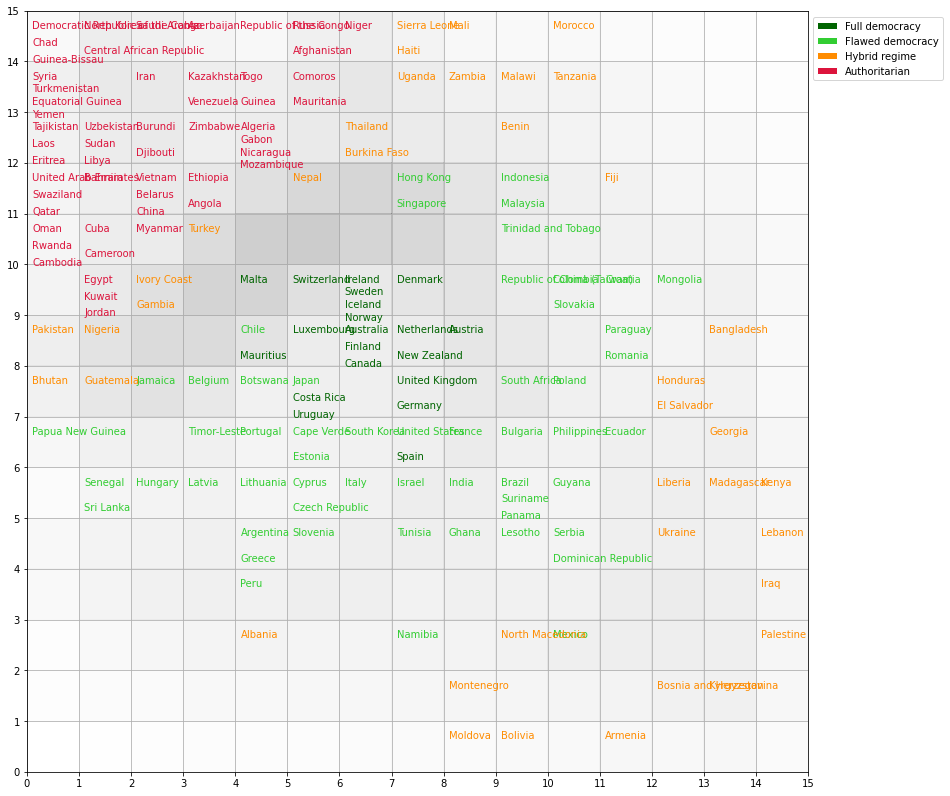

In [8]:

category_color = {'Full democracy': 'darkgreen',
                  'Flawed democracy': 'limegreen',
                  'Hybrid regime': 'darkorange',
                  'Authoritarian': 'crimson'}
colors_dict = {c: category_color[dm] for c, dm in zip(democracy_index.country,
                                                      democracy_index.category)}
country_map = som.labels_map(X, democracy_index.country)
    
plt.figure(figsize=(14, 14))
for p, countries in country_map.items():
    countries = list(countries)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(countries):
        off_set = (i+1)/len(countries) - 0.05
        plt.text(x, y+off_set, c, color=colors_dict[c], fontsize=10)
plt.pcolor(som.distance_map().T, cmap='gray_r', alpha=.2)
plt.xticks(np.arange(size+1))
plt.yticks(np.arange(size+1))
plt.grid()

legend_elements = [Patch(facecolor=clr,
                         edgecolor='w',
                         label=l) for l, clr in category_color.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .95))

## Magnitude dos pesos associados a cada feature

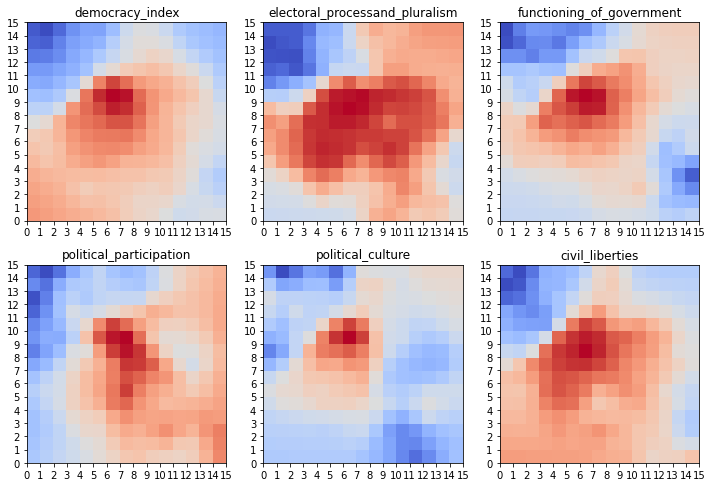

In [9]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

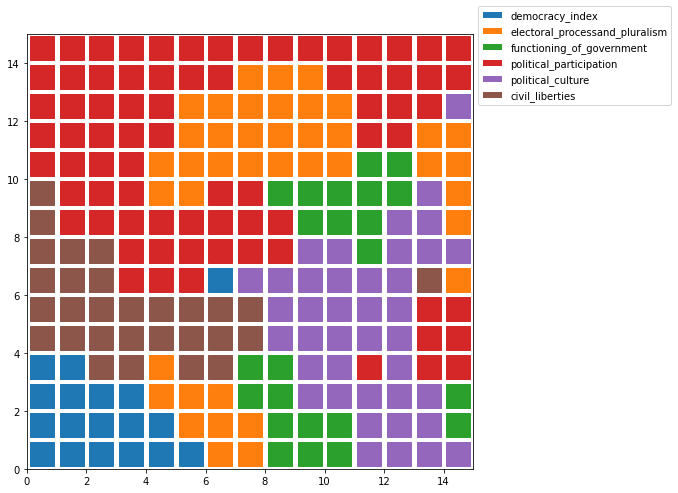

In [10]:

Z = np.zeros((size, size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, size])
plt.ylim([0, size])
plt.show()